In [1]:
%%capture
from graph_rag.document import Document
from graph_rag.documents_graph import DocumentsGraph

In [2]:
documents = [
    "i think mitski's the greatest musician of our times tbh.",
    "laurel hell was an amazing album, right?.",
    "the land is inhospitable and so are we is even better than laurel hell.",
    "the land is inhospitable and so are we and laurel hell are two of mitski's albums.",
    "mitski is better than laufey",
    "laufey is okay i guess"
]

In [3]:

mdocuments = ["Cardiovascular disease (CVD) encompasses a spectrum of disorders involving the heart and vasculature, prominently including atherosclerosis, characterized by endothelial dysfunction and the accumulation of lipid-laden plaques. These pathophysiological processes often precipitate myocardial infarction and cerebrovascular accidents, arising from the rupture of vulnerable plaques and subsequent thrombogenesis.",
             #"The intricate interplay between hyperlipidemia, hypertension, and inflammatory mediators such as C-reactive protein exacerbates the progression of atherogenesis.",
             "Management of cardiovascular disease necessitates a multifaceted approach involving antihypertensive agents, statins to modulate dyslipidemia, and antiplatelet therapy to mitigate thrombosis risk.",
             "Emerging therapeutic interventions targeting molecular pathways, including PCSK9 inhibitors and SGLT2 inhibitors, show promise in reducing cardiovascular morbidity and mortality.",
             "The epidemiological burden of cardiovascular disease underscores the imperative for ongoing research into genetic predispositions and the optimization of primary and secondary prevention strategies."
             "Cardiovascular disease also significantly intersects with metabolic syndrome, wherein insulin resistance and visceral adiposity contribute to endothelial dysfunction and systemic inflammation, further accelerating atherogenic processes.",
             "Advanced imaging techniques, such as coronary artery calcium scoring and carotid intima-media thickness measurement, enhance the stratification of cardiovascular risk, enabling more tailored therapeutic interventions.",
             "Role of novel biomarkers, including high-sensitivity troponins and natriuretic peptides, is pivotal in the early detection and prognostication of acute coronary syndromes and heart failure within the broader spectrum of cardiovascular disease."
]

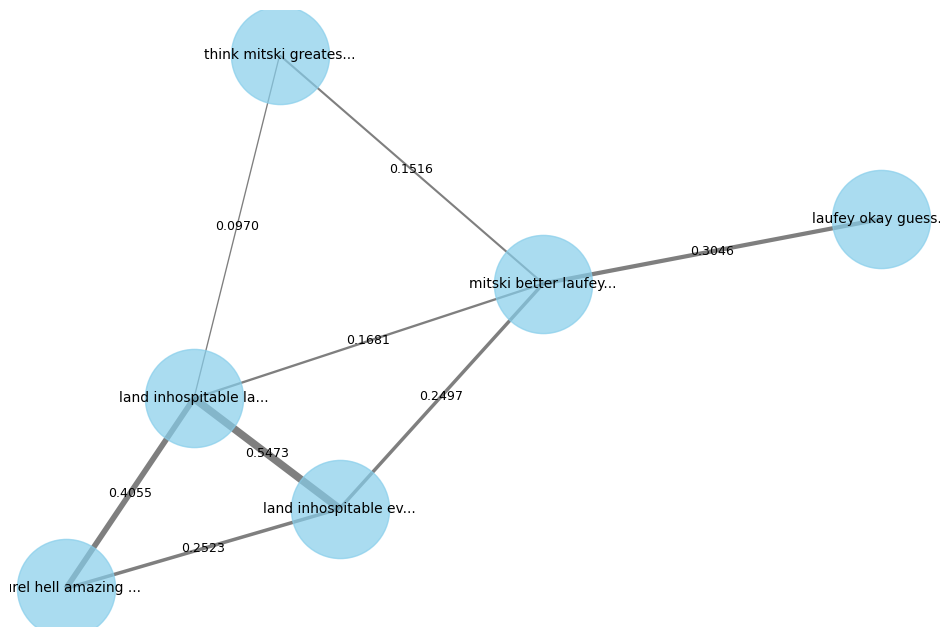

In [4]:
documents_graph = DocumentsGraph(documents=documents)
documents_graph.plot()

In [5]:
#document = "i think mitski's the greatest musician of our times tbh."
document = documents[4]

In [6]:
documents_graph.find_connected_documents(document)

think mitski greatest musician time tbh mitski better laufey
laurel hell amazing album right mitski better laufey
land inhospitable even better laurel hell mitski better laufey
land inhospitable laurel hell two mitski album mitski better laufey
mitski better laufey mitski better laufey


[('laufey okay guess', 0.3045514910803254),
 ('land inhospitable even better laurel hell', 0.24968798387885188),
 ('land inhospitable laurel hell two mitski album', 0.16812918728760345)]

In [7]:
documents_graph.find_k_closest_sentences(document, 5)

[('mitski better laufey', 1.0),
 ('laufey okay guess', 0.2702325988900178),
 ('land inhospitable even better laurel hell', 0.21683089877927111),
 ('land inhospitable laurel hell two mitski album', 0.15272272937620826),
 ('think mitski greatest musician time tbh', 0.13895780366763236)]

In [8]:
documents_graph.save("med_graph")

In [9]:
documents_graph.load_from_file("med_graph")